# Fluxonium Floquet analysis

How easy is it to apply the Floquet analysis to a different qubit type? As easy as initializing another qubit that is already implemented in `scqubits`. Below we plot the displaced state overlap plot, as well as the branch analysis and quasienergies.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq
from cycler import cycler

import floquet as ft


color_cycler = cycler(plt.rcParams["axes.prop_cycle"])
ls_cycler = cycler(ls=["-", "--", "-.", ":"])
alpha_cycler = cycler(alpha=[1.0, 0.6, 0.2])
color_ls_alpha_cycler = alpha_cycler * ls_cycler * color_cycler

In [2]:
filepath = ft.generate_file_path("h5py", "fluxonium_floquet", "out")

# Fluxonium parameters
num_states = 20
qubit_params = {"EJ": 10.0, "EC": 1.0, "EL": 1.0, "flux": 0.5, "cutoff": 110}
fluxonium = scq.Fluxonium(**qubit_params, truncated_dim=num_states)
state_indices = [0, 1]  # get data for ground and first excited states


# Express operators in eigenbasis of transmon
def get_H0_H1(qubit_instance: scq.GenericQubit) -> tuple[qt.Qobj, qt.Qobj]:
    hilbert_space = scq.HilbertSpace([qubit_instance])
    hilbert_space.generate_lookup()
    evals = hilbert_space["evals"][0][0:num_states]
    H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))
    H1 = hilbert_space.op_in_dressed_eigenbasis(qubit_instance.n_operator)
    return H0, H1


H0, H1 = get_H0_H1(fluxonium)

omega_d_values = 2.0 * np.pi * np.linspace(7.7, 10.0, 120)
chi_ac_values = 2.0 * np.pi * np.linspace(0.0, 0.2, 89)
chi_to_amp = ft.ChiacToAmp(H0, H1, state_indices, omega_d_values)
drive_amplitudes = chi_to_amp.amplitudes_for_omega_d(chi_ac_values)

model = ft.Model(
    H0, H1, omega_d_values=omega_d_values, drive_amplitudes=drive_amplitudes
)
options = ft.Options(num_cpus=6, fit_range_fraction=0.5)

In [ ]:
floquet_analysis_flux = ft.FloquetAnalysis(
    model, state_indices=state_indices, options=options
)
data_vals_flux = floquet_analysis_flux.run(filepath=filepath)

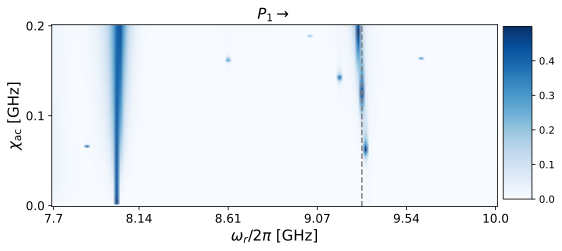

In [4]:
fluxonium_idx = 1
omega_d_idx = 83  # 19

plot_data_flux = np.clip(
    1 - data_vals_flux["displaced_state_overlaps"][:, :, fluxonium_idx].T ** 2, 0.0, 0.5
)
fig, ax = plt.subplots(figsize=(8, 8))
xticks = omega_d_values / (2.0 * np.pi)
yticks = chi_ac_values / (2.0 * np.pi)
num_x_pts = len(xticks)
num_y_pts = len(yticks)
im = plt.imshow(
    plot_data_flux, origin="lower", cmap="Blues", aspect=0.55, interpolation="none"
)
plt.axvline(omega_d_idx, color="grey", ls="--")
ax.set_title(f"$P_{fluxonium_idx}$" + r"$\rightarrow$", fontsize=15)
xticklabel_locations = np.linspace(0, num_x_pts - 1, 6, dtype=int)
ax.set_xticks(xticklabel_locations)
ax.set_xticklabels(
    np.array(np.around(xticks[xticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
yticklabel_locations = np.linspace(0, num_y_pts - 1, 3, dtype=int)
ax.set_yticks(yticklabel_locations)
ax.set_yticklabels(
    np.array(np.around(yticks[yticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
ax.set_ylabel(r"$\chi_{\rm ac}$ [GHz]", fontsize=15)
ax.set_xlabel(r"$\omega_r/2\pi$ [GHz]", fontsize=15)
cax = plt.axes([0.91, 0.35, 0.05, 0.3])
cbar = plt.colorbar(im, cax=cax)
plt.show()

At the linecut position we observe a resonance. Lets compare with the Blais results to determine the state that is responsible.

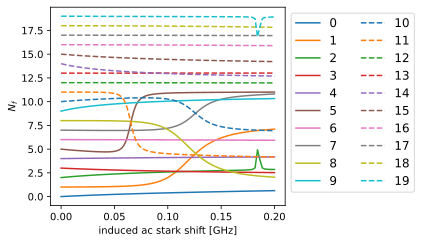

In [8]:
fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(range(num_states), color_ls_alpha_cycler, strict=False):
    plt.plot(
        chi_ac_values / 2 / np.pi,
        data_vals_flux["avg_excitation"][omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel(r"$N_{f}$")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
# ax.set_ylim(-27 / 2 / np.pi, -20 / 2 / np.pi)
plt.tight_layout()
plt.show()

We see its the eighth excited state. Looking at the quasienergies confirms an avoided crossing (with tens of MHz strength!)

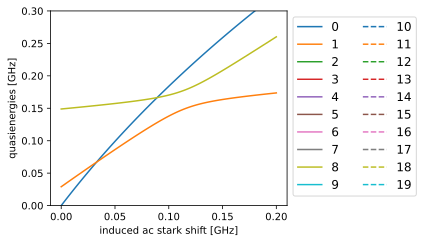

In [9]:
fig, ax = plt.subplots(figsize=(6, 3.5))
for curve_idx, sty in zip(range(num_states), color_ls_alpha_cycler, strict=False):
    plt.plot(
        chi_ac_values / 2 / np.pi,
        data_vals_flux["quasienergies"][omega_d_idx, :, curve_idx] / 2 / np.pi,
        label=curve_idx,
        **sty,
    )
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel("quasienergies [GHz]")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0.0, 0.3)
plt.tight_layout()
plt.show()